DeepSpeech
--

The DeepSpeech implementation pipeline has three main parts. Since The Switchboard Hub500 dataset is not available publicly, I have implemented it using the Tensorflow Speech Recognition dataset from Google Brain(https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/data) with just a few classes. The architecture is the same.

The three parts are :

    1) Preparing X : Conversion from .wav audio files to spectogram images

    2) Preparing Y : Creating a vector to encapsulate data about when an utterance is ended"

    3) Model Prep and Training :
     The model is the same as the deepspeech architecture.It consists of convolutional layers to read the image, followed      by a few Dense Layers and then a Bidirectional RNN layer followed by two more dense layers which output the Y.
       Dropout is applied as given in the paper of around 10% for the dense layers.


Preparing X : 
--

In [1]:
import matplotlib.pyplot as plt
from matplotlib.backend_bases import RendererBase
from scipy import signal
from scipy.io import wavfile
#import soundfile as sf
import os
import numpy as np
from PIL import Image
from scipy.fftpack import fft
from scipy.io import wavfile
import librosa
from sklearn.decomposition import PCA

%matplotlib inline

In [2]:
audio_path = 'data/train/audio/'
pict_Path = 'data/picts/train/'
test_pict_Path = 'data/picts/test/'
test_audio_path = 'data/test/audio/'
samples = []

In [3]:
if not os.path.exists(pict_Path):
    os.makedirs(pict_Path)

if not os.path.exists(test_pict_Path):
    os.makedirs(test_pict_Path)


subFolderList = []
for x in os.listdir(audio_path):
    if os.path.isdir(audio_path + '/' + x):
        subFolderList.append(x)
        if not os.path.exists(pict_Path + '/' + x):
            os.makedirs(pict_Path +'/'+ x)

Count of training samples :

In [4]:
sample_audio = []
total = 0
for x in subFolderList:
    
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    total += len(all_files)
    # collect the first file from each dir
    sample_audio.append(audio_path  + x + '/'+ all_files[0])
    
    # show file counts
    print('count: %d : %s' % (len(all_files), x ))
print(total)

count: 1713 : bed
count: 1731 : bird
count: 1733 : cat
count: 1746 : dog
count: 2359 : down
count: 2352 : eight
count: 2357 : five
count: 2372 : four
count: 2372 : go
count: 1742 : happy
count: 1750 : house
count: 2353 : left
count: 1746 : marvin
count: 2364 : nine
count: 2375 : no
count: 2357 : off
count: 2367 : on
count: 2370 : one
count: 2367 : right
count: 2377 : seven
count: 1734 : sheila
count: 2369 : six
count: 2380 : stop
count: 2356 : three
count: 1733 : tree
count: 2373 : two
count: 2375 : up
count: 1745 : wow
count: 2377 : yes
count: 2376 : zero
count: 6 : _background_noise_
64727


Sample File Path  :

In [5]:
sample_audio[0]

'data/train/audio/bed/00176480_nohash_0.wav'

In [6]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, _, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, np.log(spec.T.astype(np.float32) + eps)

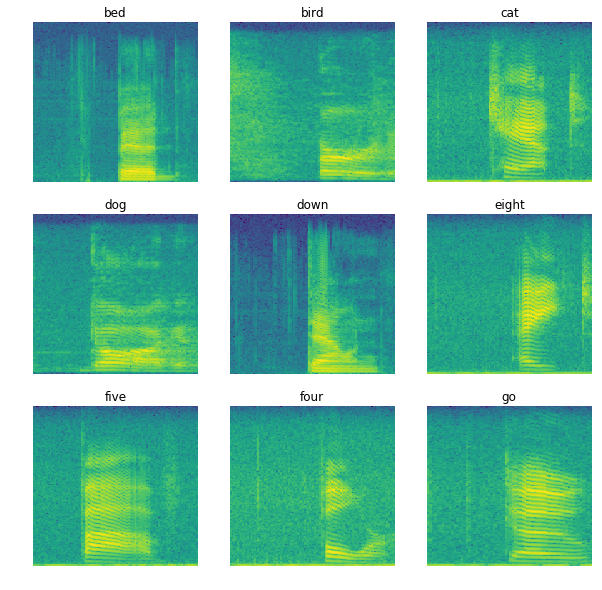

In [7]:
fig = plt.figure(figsize=(10,10))

# for each of the samples
for i, filepath in enumerate(sample_audio[:9]):
    # Make subplots
    plt.subplot(3,3,i+1)
    
    # pull the labels
    label = filepath.split('/')[-2]
    plt.title(label)
    
    # create spectogram
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.axis('off')

In [17]:
def wav2img(wav_path, targetdir='', figsize=(4,4)):
    """
    takes in wave file path
    and the fig size. Default 4,4 will make images 288 x 288
    """

    fig = plt.figure(figsize=figsize)    
    # use soundfile library to read in the wave files
    samplerate, test_sound  = wavfile.read(filepath)
    _, spectrogram = log_specgram(test_sound, samplerate)
    
    ## create output path
    output_file = wav_path.split('/')[-1].split('.wav')[0]
    output_file = targetdir +'/'+ output_file
    #plt.imshow(spectrogram.T, aspect='auto', origin='lower')
    plt.imsave('%s.png' % output_file, spectrogram)
    plt.close()


In [22]:
for i, x in enumerate(subFolderList):
    print(i, ':', x)
    # get all the wave files
    all_files = [y for y in os.listdir(audio_path + x) if '.wav' in y]
    for file in all_files:
        wav2img(audio_path + x + '/' + file, pict_Path + x)

0 : bed
1 : bird
2 : cat
3 : dog
4 : down
5 : eight
6 : five
7 : four
8 : go
9 : happy
10 : house
11 : left
12 : marvin
13 : nine
14 : no
15 : off
16 : on
17 : one
18 : right
19 : seven
20 : sheila
21 : six
22 : stop
23 : three
24 : tree
25 : two
26 : up
27 : wow
28 : yes
29 : zero
30 : _background_noise_


Preparing Y :
---

Since all the examples are of the same normalized size of 288x288 and were all of 1 sec , we are free to break the 1 sec into Ty parts where Ty is how many parts into which one second is broken down. We use Ty = 1000 so that each segment of y is of 1/1000 = 1ms. We set the last 100 parts of this 1000 segment to the index mapping of the labels bed,cat,dog etc. So that detecting the sound at anywhere in the last 100ms is okay.

In [8]:
labels = os.listdir(pict_Path)
labels.pop()
labels

['bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'four',
 'go',
 'happy',
 'house',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'wow',
 'yes',
 'zero']

In [9]:
lab2id = dict((x+1,y) for x,y in enumerate(labels))
id2lab = dict((y,x+1) for x,y in enumerate(labels))
id2lab

{'bed': 1,
 'bird': 2,
 'cat': 3,
 'dog': 4,
 'down': 5,
 'eight': 6,
 'five': 7,
 'four': 8,
 'go': 9,
 'happy': 10,
 'house': 11,
 'left': 12,
 'marvin': 13,
 'nine': 14,
 'no': 15,
 'off': 16,
 'on': 17,
 'one': 18,
 'right': 19,
 'seven': 20,
 'sheila': 21,
 'six': 22,
 'stop': 23,
 'three': 24,
 'tree': 25,
 'two': 26,
 'up': 27,
 'wow': 28,
 'yes': 29,
 'zero': 30}

In [10]:
Ty = 1000
Y_timedist = {}
for i in labels:
    y_zeros = np.zeros((1, Ty))
    for j in range(899,Ty):
        y_zeros[0,j] = id2lab[i]
    Y_timedist[i] = y_zeros
Y_timedist['six'] # example

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.

In [23]:
Y_cat = []
for i in labels[0:10]:
    Y_cat.append(id2lab[i])
from keras.utils import to_categorical
Y_cat = to_categorical(Y_cat)

array([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

Combining both X and Y :
--

We shall put it all together in X and Y variables. But first we have to create X by randomly picking samples from all the docs. Simultaneously we must input the correct categorical feature to Y matrix.



We do this for the first 10 classes due to size constraints. We choose 1000 images from each class.

In [79]:
import cv2
X = []
Y = []
for i in os.listdir(pict_Path)[0:10]:
    imglist = [k for k in os.listdir(pict_Path+i)][0:1000]
    for j in imglist:
        image = cv2.imread(pict_Path+i+"/"+j)
        image = cv2.resize(image,(100,100), interpolation = cv2.INTER_CUBIC)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        X.append(image.T)
        Y.append(Y_cat[id2lab[i]-1])


Shuffling :

In [80]:
X2Y = list((X[i],Y[i]) for i in range(len(X)))
X2Y[1000][1]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [81]:
from random import shuffle
shuffle(X2Y)
X2Y[0]

(array([[182, 180, 178, ..., 184, 186, 188],
        [141, 147, 150, ..., 156, 153, 148],
        [136, 132, 126, ..., 143, 138, 137],
        ...,
        [ 93,  91,  92, ...,  92,  91,  93],
        [ 74,  85,  94, ...,  89,  86,  88],
        [ 75,  75,  79, ...,  84,  86,  89]], dtype=uint8),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]))

In [82]:
Xf,Yf = [],[]
for i in X2Y:
    Xf.append(i[0])
    Yf.append(i[1])
Xf = np.array(Xf)
Yf = np.array(Yf)

In [84]:
print(Xf.shape,"\n",Yf.shape)

(10000, 100, 100) 
 (10000, 11)


Preprocessing done. Going for the Model.

Main Model : 
--

In [85]:
x = Xf.reshape(10000, 100, 100,1)
x.shape

(10000, 100, 100, 1)

In [86]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, Conv2D,Reshape
from keras.layers import SimpleRNN, Bidirectional, BatchNormalization, Reshape,MaxPooling2D,Flatten
from keras.optimizers import Adam


# input layer
X_input = Input(shape = x[0].shape)

# Step 1: CONV layer 
X = Conv2D(32, (3, 3),input_shape=(100, 100, 1))(X_input)                       # CONV2D
X = BatchNormalization()(X)                                                     # Batch normalization
X = Activation('relu')(X) 
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Conv2D(32, (3, 3))(X_input)                       # CONV2D
X = BatchNormalization()(X)                                                     # Batch normalization
X = Activation('relu')(X) 
X = MaxPooling2D(pool_size=(2, 2))(X)
X = Activation('relu')(X)  
X = Dropout(0.2)(X)                                 


# Step 2: 3 Dense Layers

X = TimeDistributed(Dense(128))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = TimeDistributed(Dense(128))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = TimeDistributed(Dense(128))(X)
X = Activation('relu')(X)
X = Dropout(0.5)(X)
X = Reshape((49*49,128))(X)

# Step 3: BiRNN Layer
X = Bidirectional(SimpleRNN(units = 1000, return_sequences = True))(X)   
X = BatchNormalization()(X)    

# Step 4: Time-distributed dense layer
X = TimeDistributed(Dense(1, activation = "sigmoid"))(X) # time distributed  (sigmoid)
X = Flatten()(X)
X = Dense(11,activation = 'relu')(X)

model = Model(inputs = [X_input] , outputs = X)
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 100, 100, 1)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 98, 98, 32)        320       
_________________________________________________________________
batch_normalization_38 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
activation_92 (Activation)   (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
activation_93 (Activation)   (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 49, 49, 32)        0         
__________

In [87]:
v_split = 0.3
model.fit(x=x, y=Yf,epochs=2, batch_size=10, verbose=1, validation_split=v_split)

Train on 7000 samples, validate on 3000 samples
Epoch 1/2
7000/7000 [==============================] - 1749s 250ms/step - loss: 10.3108 - acc: 0.0999 - val_loss: 10.1847 - val_acc: 0.0987
Epoch 2/2
7000/7000 [==============================] - 1753s 250ms/step - loss: 10.2469 - acc: 0.1014 - val_loss: 10.1815 - val_acc: 0.1020


In [88]:
open('model.json', 'w').write(model.to_json())
model.save_weights('weights.h5')
print("Model Saved")

Model Saved


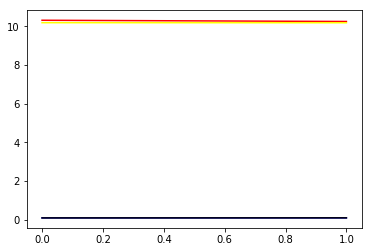

In [90]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(model.history.history['loss'],'red')
plt.plot(model.history.history['acc'],'blue')
plt.plot(model.history.history['val_loss'],'yellow')
plt.plot(model.history.history['val_acc'],'black')
plt.show()

Thus we see that the model is improving. Since I have only a local GPU I trained for about an hour for 2 epochs. Performance will certainly improve if trained on more data and more processing power.

More Improvements :

1) Use LSTMs or GRUs as used in DeepSpeech2 and 3.

2) Use More data/GPUs

3) Use a momentum/RMSProp Optimizer insted of Adam.

4) Using the Folder Background that contains background noise we can generate our own data by using pydub to input              positive samples and negative samples at specific places. The output will directly come from the LSTM which will have        a y vector with 50 or so 1s when the positive utterance is finished. Thus we can systhesize our own data and                change the model to fit it.

                                        Thanks for going through the document.